<a href="https://colab.research.google.com/github/fjpa121197/ImageCLEF2021/blob/colab/jupyter_notebooks/CNN_Modality_clf_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "fjpa121197" # username from the json file
os.environ['KAGGLE_KEY'] = "ea7bd33026696afdb7940bc87acaed0" # keya from the json file
!kaggle datasets download -d fjpa121197/imageclefmed2021 # api copied from kaggle !!!!!!!CHANGE API COMMAND TO THE NEW DATASET

100% 3.84G/3.84G [01:11<00:00, 51.0MB/s]
100% 3.84G/3.84G [01:11<00:00, 57.4MB/s]


In [ ]:
# Upload data
from zipfile import ZipFile

file_name = "/content/imageclefmed2021.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(14)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import numpy as np
from sklearn import metrics

import matplotlib.pyplot as plt


**Please make a new section if you are about to try different model architectures, use different parameters or data augmentation techniques, use class_weights, oversampling or undersampling, etc. Also, explain what is the variation. It will be good to set a fixed seed for all parts that use one, this is to make sure that improvements are because of model architecture changes and not something random.**

# CNN Modality Classification (wo targeting imbalanced dataset)
CNN model to classify image modality which class weights or image per modality frequency is not taken into consideration.

In [ ]:
##Create model
model_base = models.Sequential()
model_base.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_base.add(layers.MaxPooling2D((2, 2)))
model_base.add(layers.Conv2D(128, (3,3), activation= 'relu'))
model_base.add(layers.MaxPooling2D((2,2)))
model_base.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_base.add(layers.MaxPooling2D((2, 2)))
model_base.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_base.add(layers.Flatten())
model_base.add(layers.Dense(64, activation='relu'))
model_base.add(layers.Dense(7, activation='softmax'))
model_base.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 125, 125, 128)     36992     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 60, 60, 64)        73792     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 64)       

In [ ]:
model_base.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

#Early stopping based on val_loss, however, this metrics and params might change. Also, reducing learning rate might be implemented
callback_earlystop = EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights= True)

In [ ]:
# A generator is used for training to generate batches of data and not load all dataset to disk. And the same time, perform a split and rescale the image to a standard size.
train_datagen = ImageDataGenerator(validation_split=0.2,rescale=1./255)

# Flow from directory is used, in order to take leverage of the dataset directory structure and get the target for the images in each modality.
# We will use only the training set, and get the validation set from it. Training -> Training (0.8) and Validation (0.2)

train_generator = train_datagen.flow_from_directory(directory = '/content/ImageCLEF2020_Train_Images/Train/',
                                                    target_size=(256, 256), 
                                                    batch_size=32,
                                                    subset = 'training', seed = 14,
                                                    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(directory='/content/ImageCLEF2020_Train_Images/Train/',
                                                        target_size=(256, 256),
                                                        batch_size=32,
                                                        subset = 'validation', seed = 14,
                                                        class_mode='categorical')

Found 51806 images belonging to 7 classes.
Found 12947 images belonging to 7 classes.


In [ ]:
history = model_base.fit(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator, callbacks = [callback],
                              validation_steps=10)


Epoch 1/100
100/100 [==============================] - 20s 192ms/step - loss: 1.3823 - acc: 0.4564 - val_loss: 0.8319 - val_acc: 0.6812
Epoch 2/100
100/100 [==============================] - 19s 186ms/step - loss: 0.8868 - acc: 0.6699 - val_loss: 0.7588 - val_acc: 0.7156
Epoch 3/100
100/100 [==============================] - 19s 186ms/step - loss: 0.6907 - acc: 0.7428 - val_loss: 0.5102 - val_acc: 0.8156
Epoch 4/100
100/100 [==============================] - 19s 189ms/step - loss: 0.6015 - acc: 0.7850 - val_loss: 0.7276 - val_acc: 0.7250
Epoch 5/100
100/100 [==============================] - 19s 186ms/step - loss: 0.5412 - acc: 0.8025 - val_loss: 0.5124 - val_acc: 0.8000
Epoch 6/100
100/100 [==============================] - 19s 189ms/step - loss: 0.5220 - acc: 0.8151 - val_loss: 0.6253 - val_acc: 0.7781
Epoch 7/100
100/100 [==============================] - 19s 189ms/step - loss: 0.5212 - acc: 0.8219 - val_loss: 0.5908 - val_acc: 0.7594
Epoch 8/100
100/100 [===========================

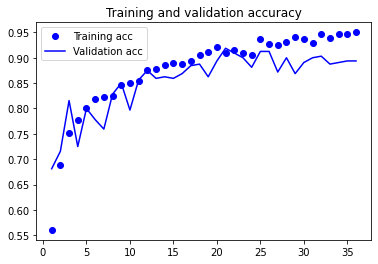

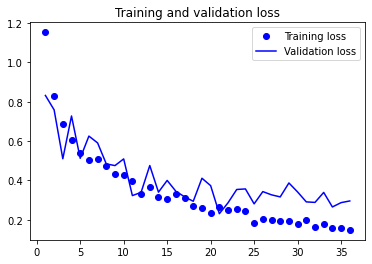

In [ ]:
model_base.save('ImageCLEF_Modality_Detection.h5')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('this is a test2.png', bbox_inches='tight')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('this is a test1.png', bbox_inches='tight')
plt.show()

In [ ]:
#Now, lets use the model_base to predict the image modality using the validation set (which hasnt been used)

#Create image generator to load new images in batches and perform same data augmentation as the training data.
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory = '/content/ImageCLEF2020_Validation_Images/Validation/',
                                                                        target_size = (256,256), shuffle = False, class_mode = 'categorical', batch_size = 32)
test_steps_per_epoch = numpy.math.ceil(test_generator.samples / test_generator.batch_size) # You can either supply each image and make a single prediction or make a batch prediction

predictions = model_base.predict(test_generator,steps = test_steps_per_epoch)
prediction_classes = numpy.argmax(predictions, axis = 1) # Returns true for the index with the highest probability

Found 15970 images belonging to 7 classes.


In [ ]:
true_classes = test_generator.classes # Gets the available classes passed to the generator
class_labels = list(test_generator.class_indices.keys()) # Gets the label ffor each class
report = metrics.classification_report(true_classes,prediction_classes, target_names = class_labels)
print("Based model classification report")
print(report)

Based model classification report
              precision    recall  f1-score   support

        DRAN       0.83      0.75      0.79      1132
        DRCO       0.81      0.85      0.83        73
        DRCT       0.90      0.93      0.92      4992
        DRMR       0.83      0.83      0.83      2848
        DRPE       0.88      0.72      0.79        74
        DRUS       0.96      0.94      0.95      2134
        DRXR       0.91      0.91      0.91      4717

    accuracy                           0.89     15970
   macro avg       0.87      0.85      0.86     15970
weighted avg       0.89      0.89      0.89     15970



# CNN Modality classification (targeting imbalanced dataset using class weights)
This CNN model will use the same architecture as the previous one, same parameters. However, it will use class weights in the fit method, which are obtained use the compute_class_weight from sklearn, this is to weight the loss function and be higher for the modalities with less images.

In [ ]:
#model definiton
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3,3), activation= 'relu'))
model_1.add(layers.MaxPooling2D((2,2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(7, activation='softmax'))
model_1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 125, 125, 128)     36992     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 60, 60, 64)        73792     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 64)       

In [ ]:
model_1.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

#Early stopping based on val_loss, however, this metrics and params might change. Also, reducing learning rate might be implemented
callback_earlystop = EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights= True)

In [ ]:
# Flow from directory is used, in order to take leverage of the dataset directory structure and get the target for the images in each modality.
# We will use only the training set, and get the validation set from it. Training -> Training (0.8) and Validation (0.2)

train_generator_1 = ImageDataGenerator(validation_split=0.2,rescale=1./255).flow_from_directory(directory = '/content/ImageCLEF2020_Train_Images/Train/',
                                                    target_size=(256, 256), 
                                                    batch_size=32,
                                                    subset = 'training', seed = 14,
                                                    class_mode='categorical')

validation_generator_1 = ImageDataGenerator(validation_split=0.2,rescale=1./255).flow_from_directory(directory='/content/ImageCLEF2020_Train_Images/Train/',
                                                        target_size=(256, 256),
                                                        batch_size=32,
                                                        subset = 'validation', seed = 14,
                                                        class_mode='categorical')

Found 51806 images belonging to 7 classes.
Found 12947 images belonging to 7 classes.


In [ ]:
# Lets see the class weights (based on sklearn class_weight module) which are computed based on the amount of images per class (the higher the number of image samples -> the lower the weight)
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes),train_generator.classes)
class_weight_dict = dict(enumerate(class_weights)) # Sklear returns an array with the corresponding weights, but the fit method uses a dict
class_weight_dict

{0: 1.9625715043376142,
 1: 18.976556776556777,
 2: 0.4618319589926454,
 3: 0.808130284216766,
 4: 18.410092395167023,
 5: 1.071966561827512,
 6: 0.4883120310673755}

In [ ]:
history_1 = model_1.fit(train_generator_1,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator_1, callbacks = [callback], class_weight = class_weight_dict,
                              validation_steps=10)

Epoch 1/100
100/100 [==============================] - 19s 187ms/step - loss: 1.4135 - acc: 0.3928 - val_loss: 1.3425 - val_acc: 0.5469
Epoch 2/100
100/100 [==============================] - 19s 187ms/step - loss: 1.4054 - acc: 0.4641 - val_loss: 1.0809 - val_acc: 0.6000
Epoch 3/100
100/100 [==============================] - 19s 190ms/step - loss: 1.0457 - acc: 0.5919 - val_loss: 1.0329 - val_acc: 0.6062
Epoch 4/100
100/100 [==============================] - 18s 183ms/step - loss: 0.9964 - acc: 0.5984 - val_loss: 0.9931 - val_acc: 0.5906
Epoch 5/100
100/100 [==============================] - 19s 187ms/step - loss: 0.8032 - acc: 0.6525 - val_loss: 0.8014 - val_acc: 0.6531
Epoch 6/100
100/100 [==============================] - 20s 199ms/step - loss: 0.7898 - acc: 0.6617 - val_loss: 1.6008 - val_acc: 0.5219
Epoch 7/100
100/100 [==============================] - 19s 189ms/step - loss: 0.7233 - acc: 0.6694 - val_loss: 0.8686 - val_acc: 0.6375
Epoch 8/100
100/100 [===========================

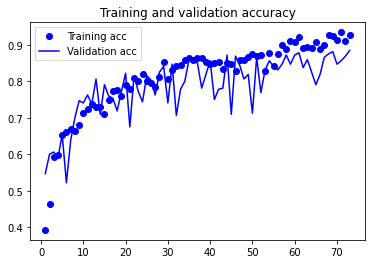

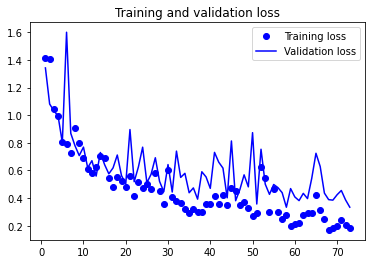

In [ ]:
model_1.save('ImageCLEF_Modality_Detection.h5')

acc = history_1.history['acc']
val_acc = history_1.history['val_acc']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('this is a test2.png', bbox_inches='tight')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('this is a test1.png', bbox_inches='tight')
plt.show()

In [ ]:
#Now, lets use the model_base to predict the image modality using the validation set (which hasnt been used)

#Create image generator to load new images in batches and perform same data augmentation as the training data.
test_generator_1 = ImageDataGenerator(rescale=1./255).flow_from_directory(directory = '/content/ImageCLEF2020_Validation_Images/Validation/',
                                                                        target_size = (256,256), shuffle = False, class_mode = 'categorical', batch_size = 32)
test_steps_per_epoch = numpy.math.ceil(test_generator.samples / test_generator.batch_size) # You can either supply each image and make a single prediction or make a batch prediction

predictions = model_1.predict(test_generator_1,steps = test_steps_per_epoch)
prediction_classes = numpy.argmax(predictions, axis = 1) # Returns true for the index with the highest probability

Found 15970 images belonging to 7 classes.


In [ ]:
true_classes_1 = test_generator_1.classes # Gets the available classes passed to the generator
class_labels_1 = list(test_generator_1.class_indices.keys()) # Gets the label ffor each class
report_1 = metrics.classification_report(true_classes_1,prediction_classes, target_names = class_labels_1)
print("Based model classification report")
print(report_1)

Based model classification report
              precision    recall  f1-score   support

        DRAN       0.75      0.76      0.75      1132
        DRCO       0.67      0.93      0.78        73
        DRCT       0.89      0.90      0.89      4992
        DRMR       0.76      0.79      0.77      2848
        DRPE       0.37      0.88      0.52        74
        DRUS       0.92      0.90      0.91      2134
        DRXR       0.91      0.85      0.88      4717

    accuracy                           0.86     15970
   macro avg       0.75      0.86      0.79     15970
weighted avg       0.86      0.86      0.86     15970



# CNN Modality Classification (wo targeting imbalanced dataset and using DenseNet-121 architecture)
This CNN model will use Densenet-121 architecture (120 layers + fully connected layer with 7 class output).

**Conclusion: Compared to previous experiments where the model arhcitecture is developed by us, using Densenet-121 architecture and adding the classification layer has increased the accuracy by 6%. However, training takes longer.**

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout

In [ ]:
model_base_densenet = DenseNet121(include_top = False, weights = 'imagenet', input_shape= (256,256,3))

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
model_densenet121 = GlobalAveragePooling2D()(model_base_densenet.output)
model_densenet121 = Dense(64, activation= 'relu')(model_densenet121)
model_densenet121 = Dropout(0.5)(model_densenet121)
predictions = Dense(7, activation= 'softmax')(model_densenet121)
model_3 = models.Model(inputs=model_base_densenet.input, outputs=predictions)

In [ ]:
model_3.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])
#Early stopping based on val_loss, however, this metrics and params might change. Also, reducing learning rate might be implemented
callback_earlystop = EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights= True)

In [ ]:
# Flow from directory is used, in order to take leverage of the dataset directory structure and get the target for the images in each modality.
# We will use only the training set, and get the validation set from it. Training -> Training (0.8) and Validation (0.2)

train_generator_1 = ImageDataGenerator(validation_split=0.2,rescale=1./255).flow_from_directory(directory = '/content/ImageCLEF2020_Train_Images/Train/',
                                                    target_size=(256, 256), 
                                                    batch_size=32,
                                                    subset = 'training', seed = 14,
                                                    class_mode='categorical')

validation_generator_1 = ImageDataGenerator(validation_split=0.2,rescale=1./255).flow_from_directory(directory='/content/ImageCLEF2020_Train_Images/Train/',
                                                        target_size=(256, 256),
                                                        batch_size=32,
                                                        subset = 'validation', seed = 14,
                                                        class_mode='categorical')

Found 51806 images belonging to 7 classes.
Found 12947 images belonging to 7 classes.


In [ ]:
history_3 = model_3.fit(train_generator_1,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator_1, callbacks = [callback_earlystop],
                              validation_steps=10)

Epoch 1/100
100/100 [==============================] - 94s 497ms/step - loss: 0.9244 - acc: 0.6964 - val_loss: 21.1219 - val_acc: 0.3469
Epoch 2/100
100/100 [==============================] - 45s 446ms/step - loss: 0.4896 - acc: 0.8504 - val_loss: 6.1085 - val_acc: 0.3375
Epoch 3/100
100/100 [==============================] - 45s 447ms/step - loss: 0.4719 - acc: 0.8474 - val_loss: 5.9496 - val_acc: 0.5688
Epoch 4/100
100/100 [==============================] - 45s 451ms/step - loss: 0.3923 - acc: 0.8744 - val_loss: 1.3070 - val_acc: 0.6500
Epoch 5/100
100/100 [==============================] - 45s 452ms/step - loss: 0.3521 - acc: 0.8919 - val_loss: 0.4524 - val_acc: 0.8594
Epoch 6/100
100/100 [==============================] - 46s 454ms/step - loss: 0.3632 - acc: 0.8855 - val_loss: 1.3542 - val_acc: 0.6906
Epoch 7/100
100/100 [==============================] - 46s 455ms/step - loss: 0.3037 - acc: 0.9003 - val_loss: 12.3552 - val_acc: 0.2344
Epoch 8/100
100/100 [=========================

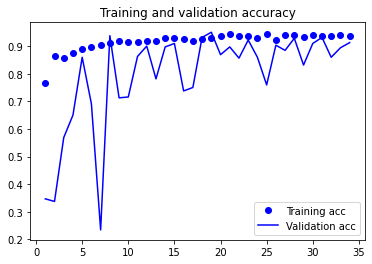

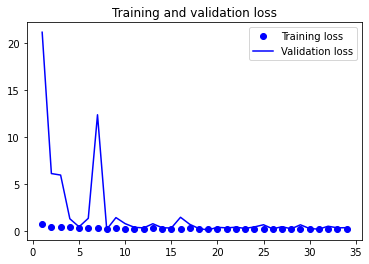

In [ ]:
model_3.save('ImageCLEF_Modality_Detection.h5')

acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('this is a test2.png', bbox_inches='tight')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('this is a test1.png', bbox_inches='tight')
plt.show()

In [ ]:
#Now, lets use the model_base to predict the image modality using the validation set (which hasnt been used)
import numpy
#Create image generator to load new images in batches and perform same data augmentation as the training data.
test_generator_3 = ImageDataGenerator(rescale=1./255).flow_from_directory(directory = '/content/ImageCLEF2020_Validation_Images/Validation/',
                                                                        target_size = (256,256), shuffle = False, class_mode = 'categorical', batch_size = 32)
test_steps_per_epoch = numpy.math.ceil(test_generator_3.samples / test_generator_3.batch_size) # You can either supply each image and make a single prediction or make a batch prediction

predictions = model_3.predict(test_generator_3,steps = test_steps_per_epoch)
prediction_classes = numpy.argmax(predictions, axis = 1) # Returns true for the index with the highest probability

Found 15970 images belonging to 7 classes.


In [ ]:
true_classes_3 = test_generator_3.classes # Gets the available classes passed to the generator
class_labels_3 = list(test_generator_3.class_indices.keys()) # Gets the label ffor each class
report_3 = metrics.classification_report(true_classes_3,prediction_classes, target_names = class_labels_3)
print("Based model classification report")
print(report_3)

Based model classification report
              precision    recall  f1-score   support

        DRAN       0.91      0.95      0.93      1132
        DRCO       0.63      0.92      0.75        73
        DRCT       0.92      0.97      0.94      4992
        DRMR       0.93      0.87      0.90      2848
        DRPE       0.91      0.96      0.93        74
        DRUS       0.99      0.99      0.99      2134
        DRXR       0.99      0.95      0.97      4717

    accuracy                           0.95     15970
   macro avg       0.90      0.94      0.92     15970
weighted avg       0.95      0.95      0.95     15970



THIS IS USING THE TEST SET:

In [ ]:
test_generator_4 = ImageDataGenerator(rescale=1./255).flow_from_directory(directory = '/content/ImageCLEF2020_Test_Images/',
                                                                        target_size = (256,256), shuffle = False, class_mode = 'categorical', batch_size = 32)
test_steps_per_epoch = numpy.math.ceil(test_generator_4.samples / test_generator_4.batch_size) # You can either supply each image and make a single prediction or make a batch prediction

predictions = model_3.predict(test_generator_4,steps = test_steps_per_epoch)
prediction_classes = numpy.argmax(predictions, axis = 1) # Returns true for the index with the highest probability

Found 3534 images belonging to 7 classes.


In [ ]:
true_classes_4 = test_generator_4.classes # Gets the available classes passed to the generator
class_labels_4 = list(test_generator_4.class_indices.keys()) # Gets the label ffor each class
report_4 = metrics.classification_report(true_classes_4,prediction_classes, target_names = class_labels_4)
print("Based model classification report")
print(report_4)

Based model classification report
              precision    recall  f1-score   support

        DRAN       0.97      0.88      0.92       325
        DRCO       1.00      0.69      0.82        49
        DRCT       0.93      0.93      0.93      1140
        DRMR       0.84      0.87      0.85       562
        DRPE       0.81      0.92      0.86        38
        DRUS       0.98      0.97      0.98       502
        DRXR       0.94      0.96      0.95       918

    accuracy                           0.93      3534
   macro avg       0.92      0.89      0.90      3534
weighted avg       0.93      0.93      0.93      3534



# CNN Modality Classification (targeting imbalanced dataset and using DenseNet-121 architecture)
This CNN model will use Densenet-121 architecture (120 layers + fully connected layer with 7 class output).

**Conclusion: Adding or targeting the imbalance dataset fact with class weight from sklearn did not help at all, maybe increasing the patience from the early stopping might help, but patience = 15 didnt help**

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
import numpy

In [ ]:
model_base_densenet_1 = DenseNet121(include_top = False, weights = 'imagenet', input_shape= (256,256,3))

In [ ]:
model_densenet121 = GlobalAveragePooling2D()(model_base_densenet_1.output)
model_densenet121 = Dense(64, activation= 'relu')(model_densenet121)
model_densenet121 = Dropout(0.5)(model_densenet121)
predictions = Dense(7, activation= 'softmax')(model_densenet121)
model_4 = models.Model(inputs=model_base_densenet_1.input, outputs=predictions)

In [ ]:
model_4.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])
#Early stopping based on val_loss, however, this metrics and params might change. Also, reducing learning rate might be implemented
callback_earlystop = EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights= True)

In [ ]:
train_generator_1 = ImageDataGenerator(validation_split=0.2,rescale=1./255).flow_from_directory(directory = '/content/ImageCLEF2020_Train_Images/Train/',
                                                    target_size=(256, 256), 
                                                    batch_size=32,
                                                    subset = 'training', seed = 14,
                                                    class_mode='categorical')

validation_generator_1 = ImageDataGenerator(validation_split=0.2,rescale=1./255).flow_from_directory(directory='/content/ImageCLEF2020_Train_Images/Train/',
                                                        target_size=(256, 256),
                                                        batch_size=32,
                                                        subset = 'validation', seed = 14,
                                                        class_mode='categorical')

Found 51806 images belonging to 7 classes.
Found 12947 images belonging to 7 classes.


In [ ]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator_1.classes),train_generator_1.classes)
class_weight_dict = dict(enumerate(class_weights)) # Sklear returns an array with the corresponding weights, but the fit method uses a dict
class_weight_dict

{0: 1.9625715043376142,
 1: 18.976556776556777,
 2: 0.4618319589926454,
 3: 0.808130284216766,
 4: 18.410092395167023,
 5: 1.071966561827512,
 6: 0.4883120310673755}

In [ ]:
history_4 = model_4.fit(train_generator_1,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator_1, callbacks = [callback_earlystop], class_weight = class_weight_dict,
                              validation_steps=10)

Epoch 1/100
100/100 [==============================] - 59s 499ms/step - loss: 1.5539 - acc: 0.5252 - val_loss: 4.4819 - val_acc: 0.4250
Epoch 2/100
100/100 [==============================] - 47s 470ms/step - loss: 1.2665 - acc: 0.5539 - val_loss: 26.9253 - val_acc: 0.1219
Epoch 3/100
100/100 [==============================] - 47s 473ms/step - loss: 1.1570 - acc: 0.4513 - val_loss: 2.5581 - val_acc: 0.3063
Epoch 4/100
100/100 [==============================] - 47s 474ms/step - loss: 1.3549 - acc: 0.4306 - val_loss: 13.4670 - val_acc: 0.3750
Epoch 5/100
100/100 [==============================] - 47s 473ms/step - loss: 1.1943 - acc: 0.4825 - val_loss: 1.7313 - val_acc: 0.4156
Epoch 6/100
100/100 [==============================] - 47s 473ms/step - loss: 1.0418 - acc: 0.4488 - val_loss: 3.0306 - val_acc: 0.3500
Epoch 7/100
100/100 [==============================] - 47s 473ms/step - loss: 1.3694 - acc: 0.4360 - val_loss: 1.3195 - val_acc: 0.4656
Epoch 8/100
100/100 [=========================

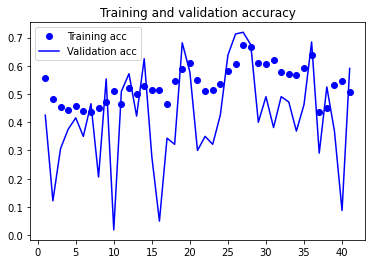

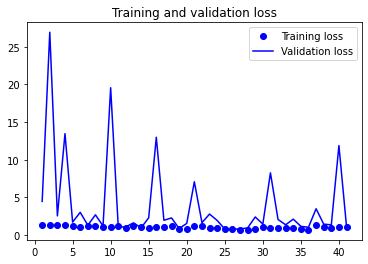

In [ ]:
model_4.save('ImageCLEF_Modality_Detection.h5')

acc = history_4.history['acc']
val_acc = history_4.history['val_acc']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('this is a test2.png', bbox_inches='tight')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('this is a test1.png', bbox_inches='tight')
plt.show()

In [ ]:
#Create image generator to load new images in batches and perform same data augmentation as the training data.
test_generator_5 = ImageDataGenerator(rescale=1./255).flow_from_directory(directory = '/content/ImageCLEF2020_Validation_Images/Validation/',
                                                                        target_size = (256,256), shuffle = False, class_mode = 'categorical', batch_size = 32)
test_steps_per_epoch = numpy.math.ceil(test_generator_5.samples / test_generator_5.batch_size) # You can either supply each image and make a single prediction or make a batch prediction

predictions = model_4.predict(test_generator_5,steps = test_steps_per_epoch)
prediction_classes = numpy.argmax(predictions, axis = 1) # Returns true for the index with the highest probability

Found 15970 images belonging to 7 classes.


In [ ]:
true_classes_5 = test_generator_5.classes # Gets the available classes passed to the generator
class_labels_5 = list(test_generator_5.class_indices.keys()) # Gets the label ffor each class
report_5 = metrics.classification_report(true_classes_5,prediction_classes, target_names = class_labels_5)
print("Based model classification report")
print(report_5)

Based model classification report
              precision    recall  f1-score   support

        DRAN       0.39      0.78      0.52      1132
        DRCO       0.11      1.00      0.21        73
        DRCT       0.91      0.68      0.78      4992
        DRMR       0.65      0.73      0.69      2848
        DRPE       0.12      0.88      0.20        74
        DRUS       0.95      0.87      0.91      2134
        DRXR       0.77      0.59      0.67      4717

    accuracy                           0.70     15970
   macro avg       0.56      0.79      0.57     15970
weighted avg       0.78      0.70      0.72     15970

